In [76]:
from pathlib import Path
import pandas as pd
import tarfile
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Load

In [77]:
# Loading data
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [78]:
housing = load_housing_data()

# Data Inspection

In [79]:
housing.head()          

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='longitude', ylabel='latitude'>

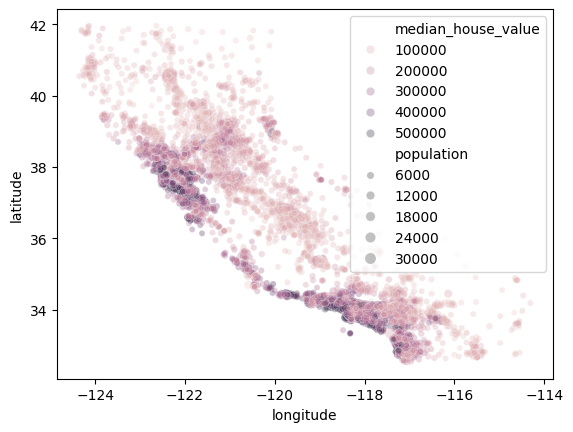

In [80]:
sns.scatterplot(data=housing, x="longitude", y = "latitude", size="population", hue="median_house_value" , alpha= 0.3 )

In [81]:
housing.info()
# almost all data is numerical, except for ocean_proximity

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [82]:
housing.describe()
# Numerical value overview. Pay attention to percentiles and std.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [83]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

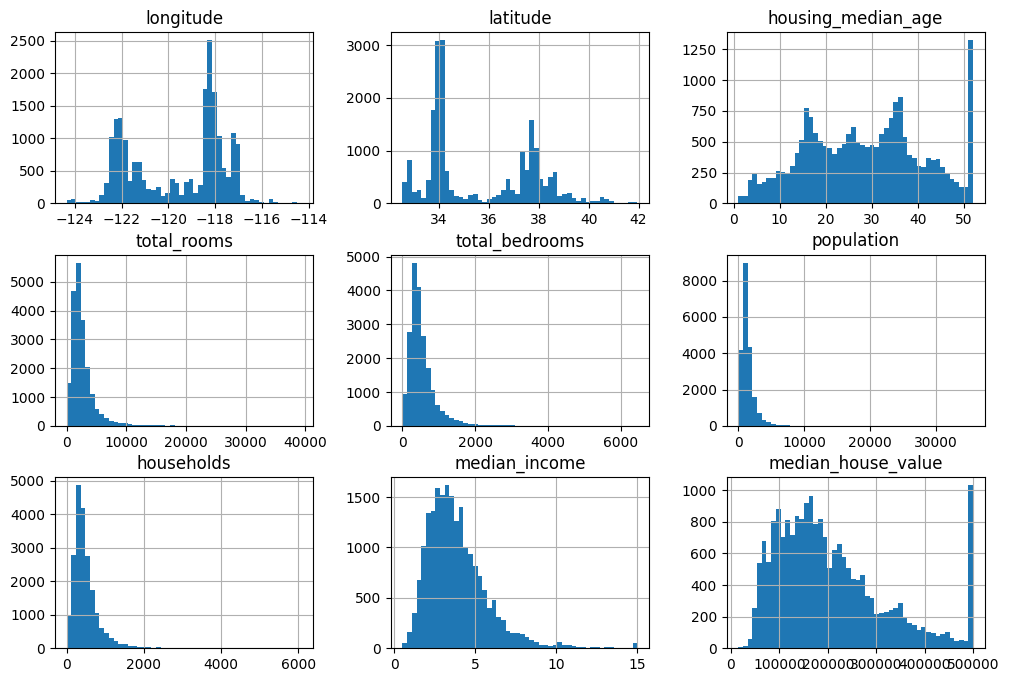

In [84]:
#histogram for all features
housing.hist(bins=50, figsize=(12,8))
plt.show()

- housing_median_age was capped at 50
- median_house_value was capped at 500,000
- Data is right skewed in most distributions

# Create a Test Set
Avoid data snooping right away

In [85]:
# Defining a train-test splitter in numpy
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

If we rerun this code multiple times, we wil end up touching the test set, which would mean a data leakage.
For this, we use random state seeds.  

In [86]:
np.random.seed(42) #(This unsures that the same split is always performed)
train, test = shuffle_and_split_data(housing, 0.2)
len(train)
len(test)

4128

In [87]:
# We can achieve a similar result with train_test_split
train_set, test_set= train_test_split(housing, test_size=0.2, random_state=42)


Solutions for randomness:
- Use np.random.seed
- Save datasets after splitting into a file.
- Using Hash values

The problem with random seed , is that when we insert new data to our dataset, this will break.
For this, we need to use hash values. 

In [88]:
# hash value approach
from zlib import crc32

In [89]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 **32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data[~in_test_set], data[in_test_set]

In [90]:
housing_with_id = housing.reset_index()
train, test = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [91]:
len(train)
len(test)

4128

Esta partición es consistente con el tiempo, en caso se agregen nuevos datos. Los antiguos datos siguen teniendo los mismos hashs, y los nuevos datos se asignan al test o train set dependiendo de su hash value. 

Stratified sampling

Es importante tener muestras representativas en ambos grupos ( train y test ), tanto para entrenar bien el modelo , como para evaluar bien las predicciones realizadas. 
Vamos a realizar una estratificación que dependa del 'median_income', ya que asumimos que es un factor clave en la prediccion.

In [92]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3, 4.5, 6, np.inf], labels = [1,2,3,4,5]) 

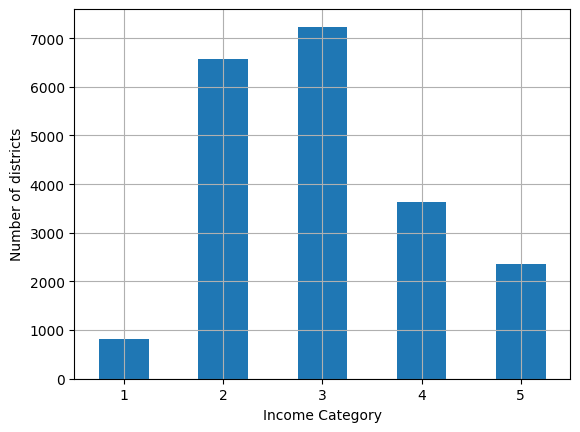

In [93]:
# Visualizamos la cantidad de datos en cada strato
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Number of districts')
plt.show()

In [94]:
# % of data in each strata
housing['income_cat'].value_counts() / len(housing) * 100

income_cat
3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: count, dtype: float64

In [95]:
# Stratified split
st_train_set, st_test_set = train_test_split(housing, stratify=housing['income_cat'], random_state=42)
train_set, test_set = train_test_split(housing, random_state=42)

In [96]:
pd.DataFrame({
    'real' : housing['income_cat'].value_counts().sort_index()/len(housing),
    'stratified': st_test_set['income_cat'].value_counts().sort_index()/len(st_test_set),
    'random': test_set['income_cat'].value_counts().sort_index()/len(test_set),
})

,real,stratified,random
income_cat,,,
1,0.039826,0.039922,0.042636
2,0.318847,0.318798,0.311434
3,0.350581,0.350581,0.342636
4,0.176308,0.176357,0.183527
5,0.114438,0.114341,0.119767


Otra forma es usar splitters . Los splitters no dividen la data per se, sino los índices.

In [97]:
## Stratified split with other methods
# Splitter method
from sklearn.model_selection import StratifiedShuffleSplit

In [98]:
# Definimos los parámetros del splitter
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [99]:
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [100]:
strat_splits[0][0]['income_cat'].value_counts().sort_index()/len(strat_splits[0][0])

income_cat
1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: count, dtype: float64

In [101]:
# Dropping 'income_cat'. as we will not use this column in our predictions. and was just used for stratified splitting.
for set_ in [st_train_set, st_test_set]:
    set_.drop("income_cat", axis=1, inplace=True)

# Data exploration
- We will explore the data (Only train_Set)
- If the set is too big, we might wanna use a exploration set, but in this case is not necessary
- We save the set aside since we will be making some changes to our data.

In [102]:
#saving set
housing = st_train_set.copy()

In [103]:
## Geography

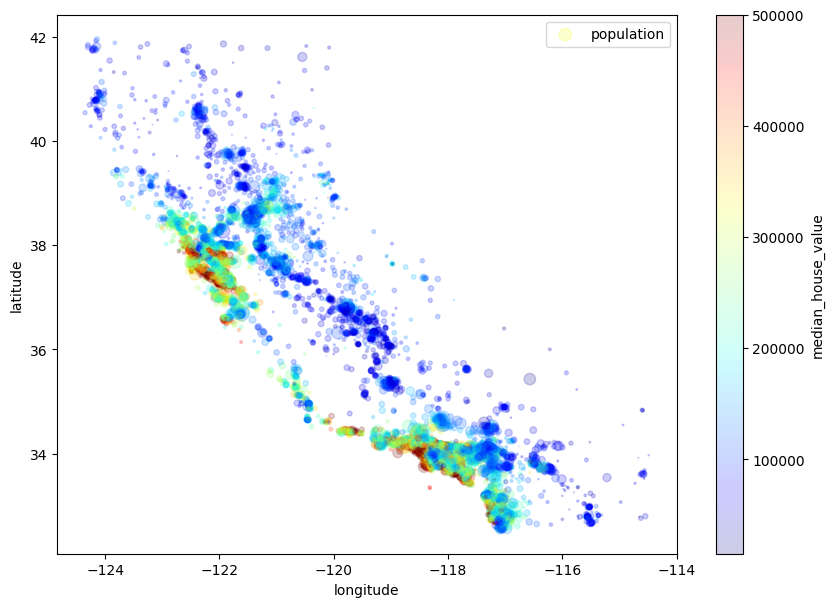

In [104]:
st_train_set.plot(kind='scatter', x='longitude', y='latitude', 
                  alpha=0.2,                    # Circle transparency
                  s=housing['population']/100, label="population", # Circle radius
                  c="median_house_value",       # circle Color
                  colorbar=True,                # color bar at the right
                  cmap="jet",                    # color palette
                  legend=True,                  # population legend box
                  sharex= True,                 # ???
                  figsize= (10,7)
                  )
plt.show()

- Las zonas más caras se encuentran cerca a las bahías. 
- Hay zonas medias que también son de consideración.
- Un factor importante podría ser la distancia a la costa / bahía.

## Correlation

In [105]:
housing.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687152
total_rooms           0.136075
housing_median_age    0.098400
households            0.070845
total_bedrooms        0.053606
population           -0.022127
longitude            -0.051657
latitude             -0.138929
Name: median_house_value, dtype: float64

- There seems to be considerable correlation between median_income and our output value.
- Theres also some correlation between total rooms.
- Theres a slightly negative correlation with the latitude.

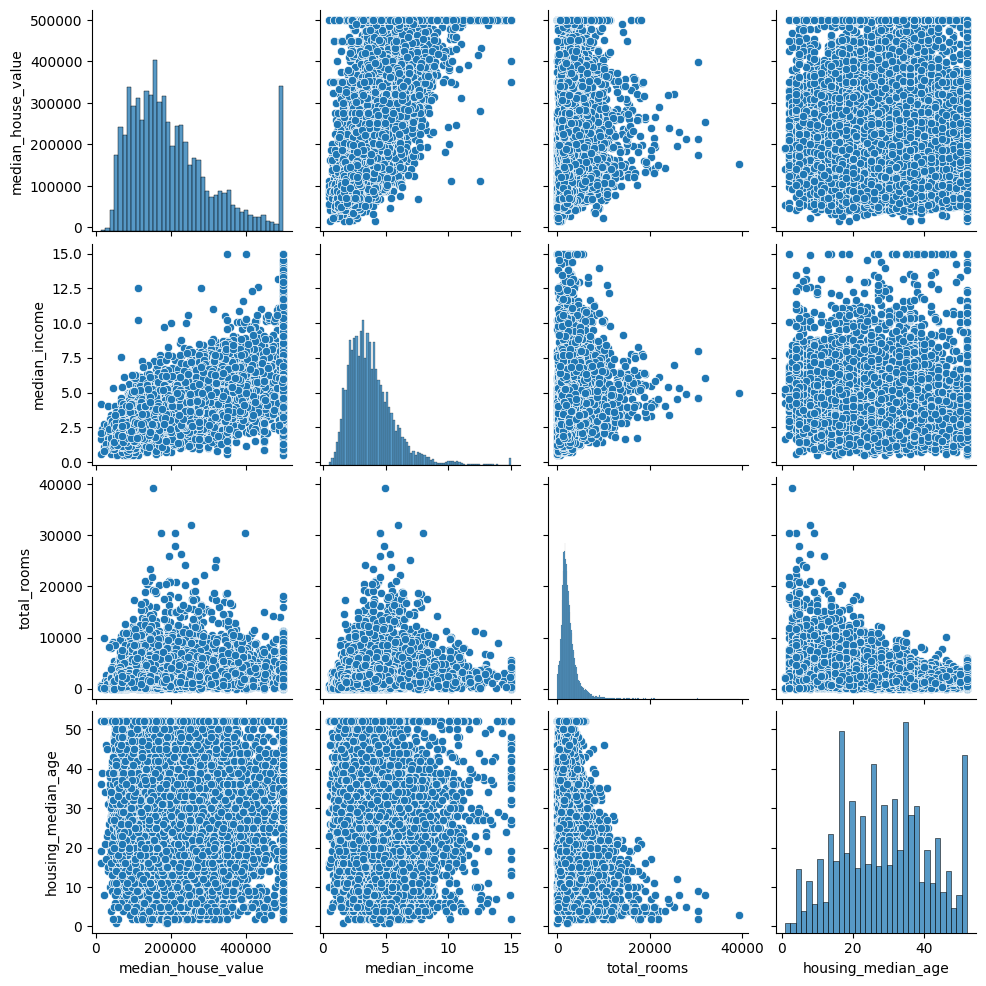

In [106]:
# Another way, Visual correlation
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
sns.pairplot(housing[attributes])
plt.show()

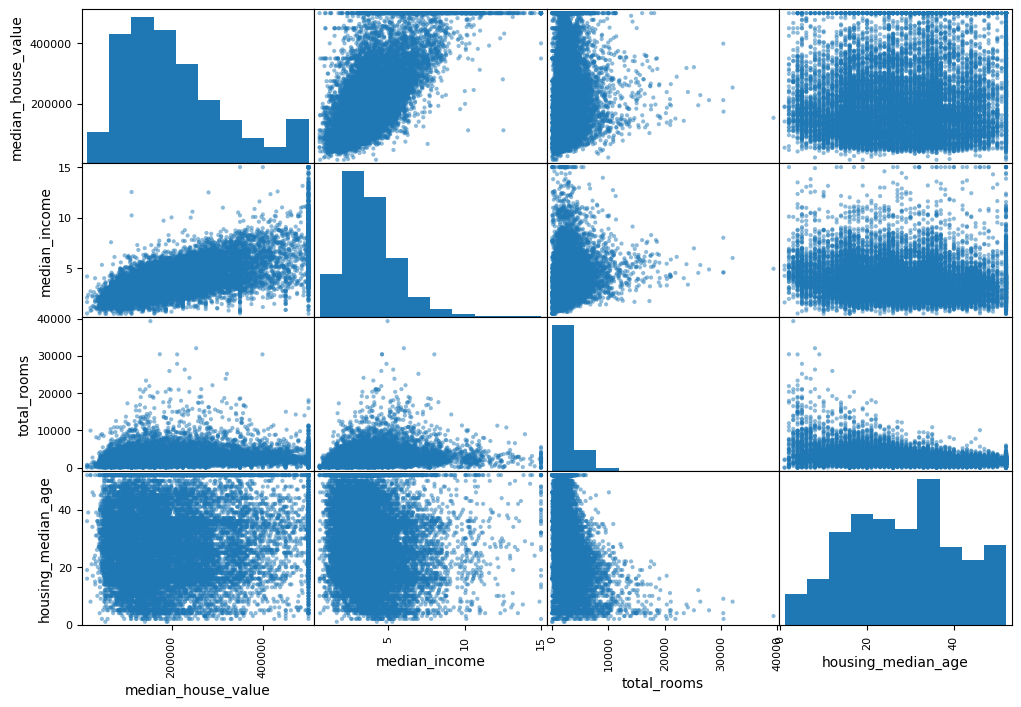

In [107]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[attributes], figsize= (12,8))
plt.show()

The only promising correlation is between median_income and median_house_value

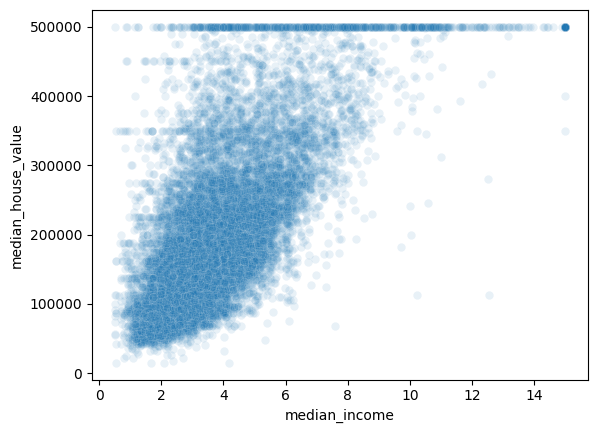

In [108]:
sns.scatterplot(housing, x='median_income', y='median_house_value', alpha=0.1)
plt.show()

Theres some straigh lines:

- 500k$  cause of the capped medina_house_value
- But theres also other visible horizontal lines (450k, 350k, 280k, etc).
- Might wanna get ride of these lines

## Attribute Combinations
It might be better to do some combinations. I.E.

In [109]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

# Data Prep
Recomendations: 

- Create functions

In [110]:
housing = st_train_set.drop("median_house_value", axis=1)
housing_labels = st_train_set["median_house_value"].copy()

In [111]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2787,-118.34,34.10,24.0,1996.0,791.0,1215.0,672.0,1.5429,<1H OCEAN
8717,-119.81,36.73,51.0,956.0,196.0,662.0,180.0,2.1010,INLAND
3521,-122.14,37.47,37.0,3373.0,815.0,2909.0,705.0,2.8868,NEAR BAY
16026,-116.89,33.48,14.0,1016.0,219.0,443.0,169.0,2.8071,INLAND
19572,-120.49,37.31,45.0,1834.0,421.0,1405.0,407.0,2.0521,INLAND
...,...,...,...,...,...,...,...,...,...
11930,-122.25,37.83,52.0,4190.0,1105.0,1786.0,1037.0,3.0897,NEAR BAY
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,<1H OCEAN
17697,-122.47,37.78,52.0,1941.0,436.0,955.0,425.0,4.1339,NEAR BAY
3469,-117.89,34.14,15.0,4644.0,967.0,2855.0,867.0,3.3654,<1H OCEAN


## Data Imputation

Let's take "total_bedrooms" columns which had some missming values.

Options:

1. Get rid of the Missing values  . dropna()
2. Get rid of the whole attribute  . drop()
3. Imputation . fillna()

In [112]:
housing["total_bedrooms"].isna().sum()

np.int64(158)

In [113]:
# opcion 1. Inplace=True para realizarlo en el mismo set.
housing.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2787,-118.34,34.10,24.0,1996.0,791.0,1215.0,672.0,1.5429,<1H OCEAN
8717,-119.81,36.73,51.0,956.0,196.0,662.0,180.0,2.1010,INLAND
3521,-122.14,37.47,37.0,3373.0,815.0,2909.0,705.0,2.8868,NEAR BAY
16026,-116.89,33.48,14.0,1016.0,219.0,443.0,169.0,2.8071,INLAND
19572,-120.49,37.31,45.0,1834.0,421.0,1405.0,407.0,2.0521,INLAND
...,...,...,...,...,...,...,...,...,...
11930,-122.25,37.83,52.0,4190.0,1105.0,1786.0,1037.0,3.0897,NEAR BAY
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,<1H OCEAN
17697,-122.47,37.78,52.0,1941.0,436.0,955.0,425.0,4.1339,NEAR BAY
3469,-117.89,34.14,15.0,4644.0,967.0,2855.0,867.0,3.3654,<1H OCEAN


In [114]:
# opcion 2. 
housing.drop(columns=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
2787,-118.34,34.10,24.0,1996.0,1215.0,672.0,1.5429,<1H OCEAN
8717,-119.81,36.73,51.0,956.0,662.0,180.0,2.1010,INLAND
3521,-122.14,37.47,37.0,3373.0,2909.0,705.0,2.8868,NEAR BAY
16026,-116.89,33.48,14.0,1016.0,443.0,169.0,2.8071,INLAND
19572,-120.49,37.31,45.0,1834.0,1405.0,407.0,2.0521,INLAND
...,...,...,...,...,...,...,...,...
11930,-122.25,37.83,52.0,4190.0,1786.0,1037.0,3.0897,NEAR BAY
9389,-118.41,34.29,32.0,1591.0,1818.0,306.0,4.2969,<1H OCEAN
17697,-122.47,37.78,52.0,1941.0,955.0,425.0,4.1339,NEAR BAY
3469,-117.89,34.14,15.0,4644.0,2855.0,867.0,3.3654,<1H OCEAN


In [115]:
# opcion 3. 
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

2787      791.0
8717      196.0
3521      815.0
16026     219.0
19572     421.0
          ...  
11930    1105.0
9389      320.0
17697     436.0
3469      967.0
9752      838.0
Name: total_bedrooms, Length: 15480, dtype: float64

### Imputers
Theres some advantages at using imputers. since they store the values, and can be reused with future data.

In [116]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")  # we create an imputer and select median as the method

In [117]:
#imputer.fit(housing) # if we try to use this method it will fail, cause theres non-numerical values

In [118]:
housing_num = housing.select_dtypes(include=[np.number]) # select_dtypes selecciona columnas con un tipo de dato específico.
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [119]:
imputer.statistics_  # imputer stores the median values from the dataset provided

array([-118.5   ,   34.26  ,   29.    , 2121.5   ,  433.5   , 1167.    ,
        408.    ,    3.5388])

In [120]:
housing_num.median().values #comparing

array([-118.5   ,   34.26  ,   29.    , 2121.5   ,  433.5   , 1167.    ,
        408.    ,    3.5388])

In [121]:
X= imputer.transform(housing_num) # we replace missing values 

In [122]:
X # es un array. 

array([[-1.1834e+02,  3.4100e+01,  2.4000e+01, ...,  1.2150e+03,
         6.7200e+02,  1.5429e+00],
       [-1.1981e+02,  3.6730e+01,  5.1000e+01, ...,  6.6200e+02,
         1.8000e+02,  2.1010e+00],
       [-1.2214e+02,  3.7470e+01,  3.7000e+01, ...,  2.9090e+03,
         7.0500e+02,  2.8868e+00],
       ...,
       [-1.2247e+02,  3.7780e+01,  5.2000e+01, ...,  9.5500e+02,
         4.2500e+02,  4.1339e+00],
       [-1.1789e+02,  3.4140e+01,  1.5000e+01, ...,  2.8550e+03,
         8.6700e+02,  3.3654e+00],
       [-1.1801e+02,  3.3840e+01,  2.8000e+01, ...,  2.1120e+03,
         8.0300e+02,  4.5000e+00]], shape=(15480, 8))

In [123]:
# We can recover the pd dataframe this way: 
pd.DataFrame(data= X, columns= housing_num.columns, index= housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
2787,-118.34,34.10,24.0,1996.0,791.0,1215.0,672.0,1.5429
8717,-119.81,36.73,51.0,956.0,196.0,662.0,180.0,2.1010
3521,-122.14,37.47,37.0,3373.0,815.0,2909.0,705.0,2.8868
16026,-116.89,33.48,14.0,1016.0,219.0,443.0,169.0,2.8071
19572,-120.49,37.31,45.0,1834.0,421.0,1405.0,407.0,2.0521
...,...,...,...,...,...,...,...,...
11930,-122.25,37.83,52.0,4190.0,1105.0,1786.0,1037.0,3.0897
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969
17697,-122.47,37.78,52.0,1941.0,436.0,955.0,425.0,4.1339
3469,-117.89,34.14,15.0,4644.0,967.0,2855.0,867.0,3.3654


#### Other imputers
- KNNImputer
- IterativeImputer

## Test and Categorical Values

In [124]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     6836
INLAND        4972
NEAR OCEAN    1951
NEAR BAY      1719
ISLAND           2
Name: count, dtype: int64

### Ordinal Encoder

In [125]:
from sklearn.preprocessing import OrdinalEncoder

In [126]:
ordinal_encoder = OrdinalEncoder()

In [127]:
housing_cat = housing[["ocean_proximity"]]

In [128]:
housing_cat

,ocean_proximity
2787,<1H OCEAN
8717,INLAND
3521,NEAR BAY
16026,INLAND
19572,INLAND
...,...
11930,NEAR BAY
9389,<1H OCEAN
17697,NEAR BAY
3469,<1H OCEAN


In [129]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [130]:
housing_cat_encoded

array([[0.],
       [1.],
       [3.],
       ...,
       [3.],
       [0.],
       [0.]], shape=(15480, 1))

In [131]:
pd.DataFrame(data= housing_cat_encoded, index= housing_cat.index, columns= housing_cat.columns)

,ocean_proximity
2787,0.0
8717,1.0
3521,3.0
16026,1.0
19572,1.0
...,...
11930,3.0
9389,0.0
17697,3.0
3469,0.0


In [132]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Problemática:

- El algoritmo considera valores numéricos cercanos como más relacionados que los lejanos, lo que puede introducir ruido.
- Se necesita otro tipo de encoding.

### One-Hot Encoding

In [133]:
from sklearn.preprocessing import OneHotEncoder

In [134]:
cat_encoder = OneHotEncoder() # we can also use sparse = false

In [135]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 

In [136]:
housing_cat_1hot # sparse matrix
# we can do operatins with sparse matrix, but we can also convert it.

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15480 stored elements and shape (15480, 5)>

In [137]:
housing_cat_1hot.toarray() # conversion to np.array.

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], shape=(15480, 5))

In [138]:
pd.DataFrame(data=housing_cat_1hot.toarray(), columns=cat_encoder.categories_, index= housing_cat.index ) #visualizing as pd. dataframe.

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
2787,1.0,0.0,0.0,0.0,0.0
8717,0.0,1.0,0.0,0.0,0.0
3521,0.0,0.0,0.0,1.0,0.0
16026,0.0,1.0,0.0,0.0,0.0
19572,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
11930,0.0,0.0,0.0,1.0,0.0
9389,1.0,0.0,0.0,0.0,0.0
17697,0.0,0.0,0.0,1.0,0.0
3469,1.0,0.0,0.0,0.0,0.0


In [139]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Alternatively, we can use pandas get_dummies

In [140]:
pd.get_dummies(housing_cat, drop_first=True)

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2787,False,False,False,False
8717,True,False,False,False
3521,False,False,True,False
16026,True,False,False,False
19572,True,False,False,False
...,...,...,...,...
11930,False,False,True,False
9389,False,False,False,False
17697,False,False,True,False
3469,False,False,False,False


Key Differences:

- One Hot encoder remembers the categories. It wil transform different dataframes, the same way.
- If OneHotEncoder finds an unknown category, it will raise an exception.
- You can set OneHotEncoder to handle the exception by ignoring it.: cat_encoder.handle_unknown = "ignore"
- panda's get_dummies will always convert any dataset without raising any exception

In [168]:
encoder = OneHotEncoder(drop='first') # we can also use drop='first' in OneHotEncoded
encoded_housing_cat = encoder.fit_transform(housing_cat)
pd.DataFrame(data=encoded_housing_cat.toarray(), columns= encoder.get_feature_names_out(), index=housing_cat.index)

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2787,0.0,0.0,0.0,0.0
8717,1.0,0.0,0.0,0.0
3521,0.0,0.0,1.0,0.0
16026,1.0,0.0,0.0,0.0
19572,1.0,0.0,0.0,0.0
...,...,...,...,...
11930,0.0,0.0,1.0,0.0
9389,0.0,0.0,0.0,0.0
17697,0.0,0.0,1.0,0.0
3469,0.0,0.0,0.0,0.0


In [164]:
encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

## Feature Scaling and Transformation

The goal is to get all attributes to the same scale.

### Min-Max scaler

In [169]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#testing the min max scaler. Scaling all numeric values to the range [-1, 1]
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
housing_num_min_max_scaled

array([[ 0.21906694, -0.67021277, -0.09803922, ..., -0.85130659,
        -0.74948665, -0.85613992],
       [-0.07910751, -0.1106383 ,  0.96078431, ..., -0.91915102,
        -0.93317155, -0.77916167],
       [-0.55172414,  0.04680851,  0.41176471, ..., -0.64347933,
        -0.73716632, -0.67077695],
       ...,
       [-0.61866126,  0.11276596,  1.        , ..., -0.88320451,
        -0.84170245, -0.49876553],
       [ 0.31034483, -0.66170213, -0.45098039, ..., -0.65010428,
        -0.67668471, -0.60476407],
       [ 0.28600406, -0.72553191,  0.05882353, ..., -0.74125874,
        -0.70057868, -0.44826968]], shape=(15480, 8))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,15480.000000,15480.000000,15480.000000,15480.000000,15322.000000,15480.000000,15480.000000,15480.000000
mean,-0.029975,-0.344288,0.079120,-0.865909,-0.826638,-0.825417,-0.813636,-0.534730
std,0.405661,0.453622,0.493860,0.110726,0.136879,0.134162,0.143122,0.261893
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.480730,-0.706383,-0.333333,-0.926548,-0.905299,-0.903938,-0.896211,-0.715869
50%,0.186613,-0.636170,0.098039,-0.892187,-0.860686,-0.857195,-0.848049,-0.580847
75%,0.286004,0.097872,0.411765,-0.839666,-0.792237,-0.788216,-0.774874,-0.412970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


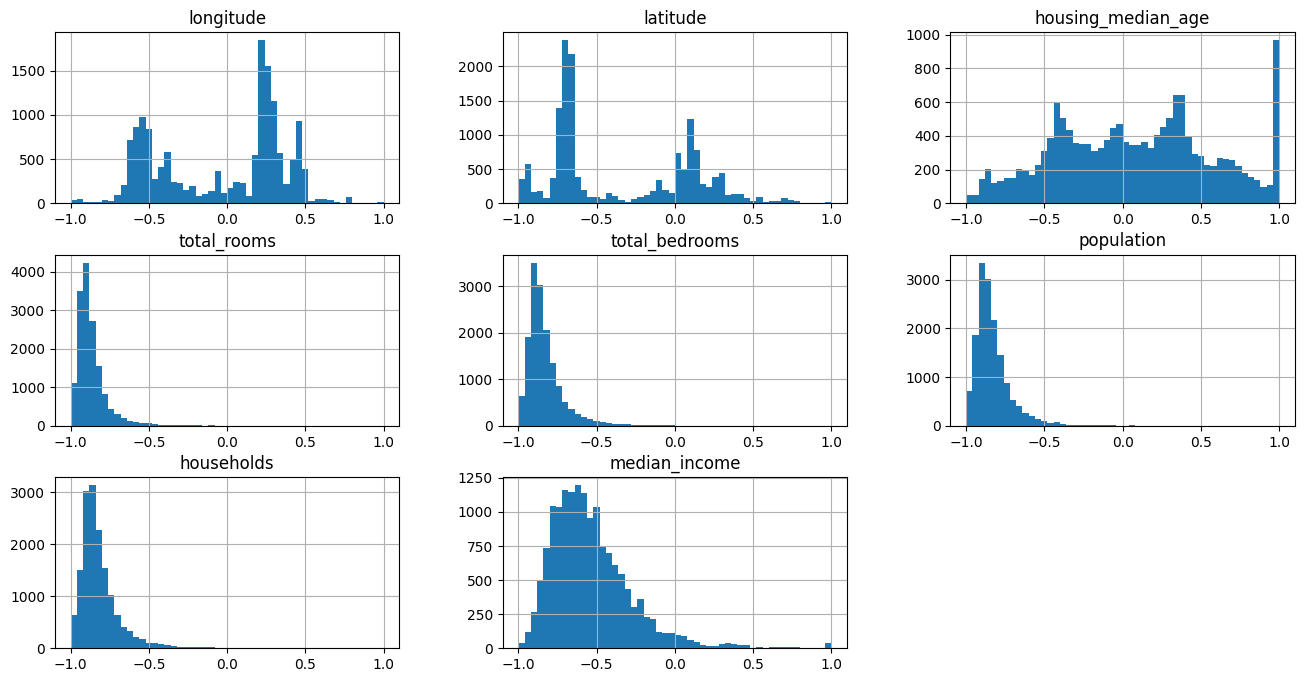

In [182]:
pd.DataFrame(data=housing_num_min_max_scaled, columns=min_max_scaler.feature_names_in_, index = housing_num.index).hist(bins=50, figsize=(16,8))
plt.show()

### StandardScaler

In [183]:
from sklearn.preprocessing import StandardScaler 

In [185]:
standard_scaler = StandardScaler()
housing_num_std_scaled = standard_scaler.fit_transform(housing_num)

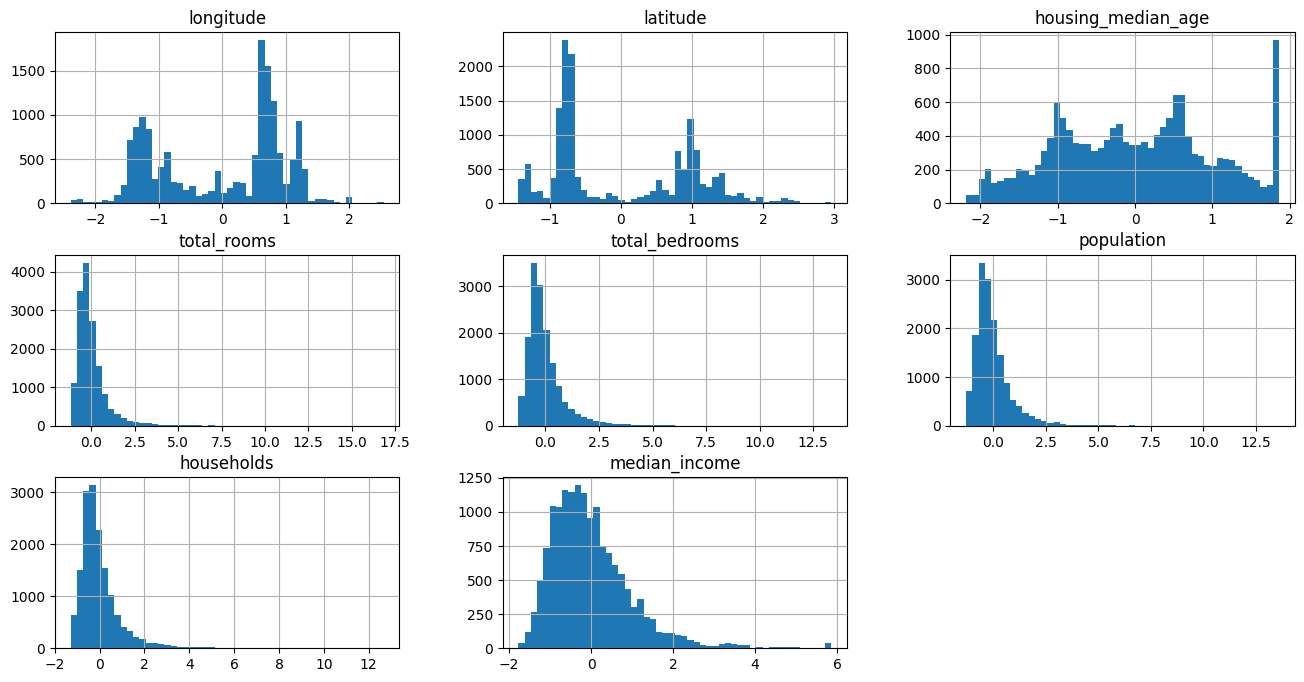

In [188]:
pd.DataFrame(data=housing_num_std_scaled, columns=standard_scaler.feature_names_in_, index=housing_num.index).hist(bins=50, figsize=(16,8))
plt.show()

### Robust Scaler

In [189]:
from sklearn.preprocessing import RobustScaler

In [190]:
robust_scaler = RobustScaler()
housing_num_robust_scaled = robust_scaler.fit_transform(housing_num)

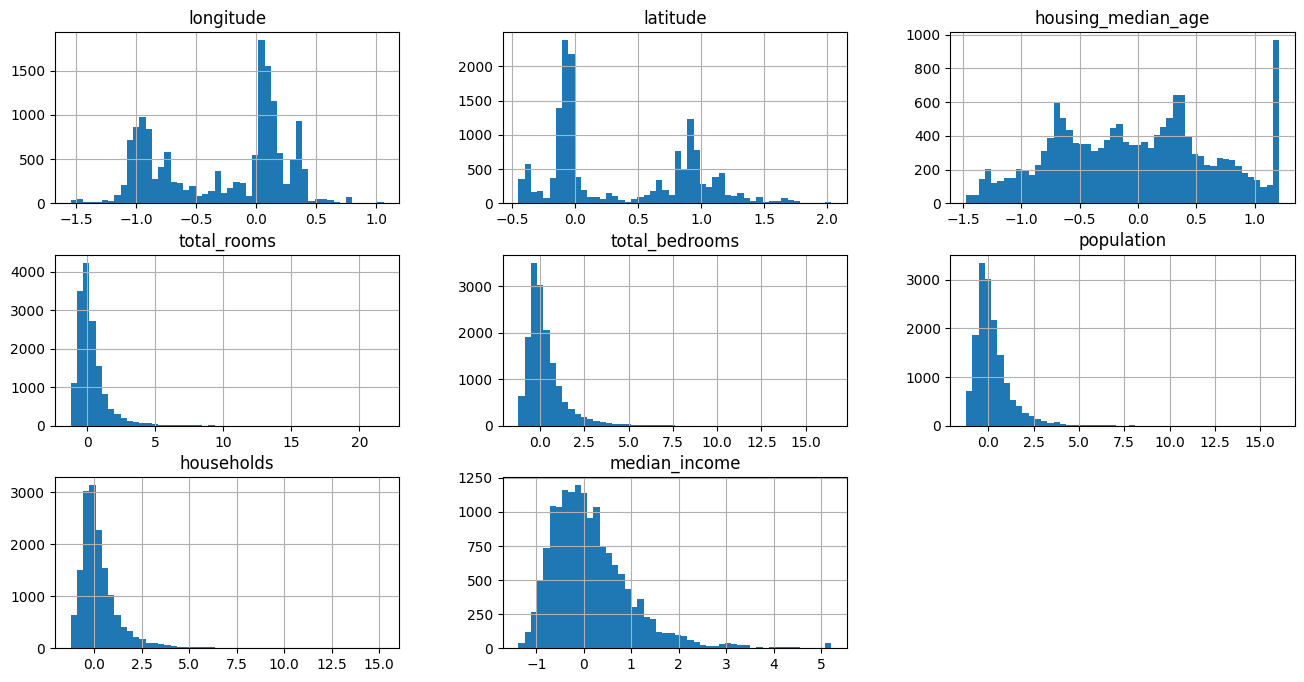

In [191]:
pd.DataFrame(data=housing_num_robust_scaled, columns=robust_scaler.feature_names_in_, index=housing_num.index).hist(bins=50, figsize=(16,8))
plt.show()

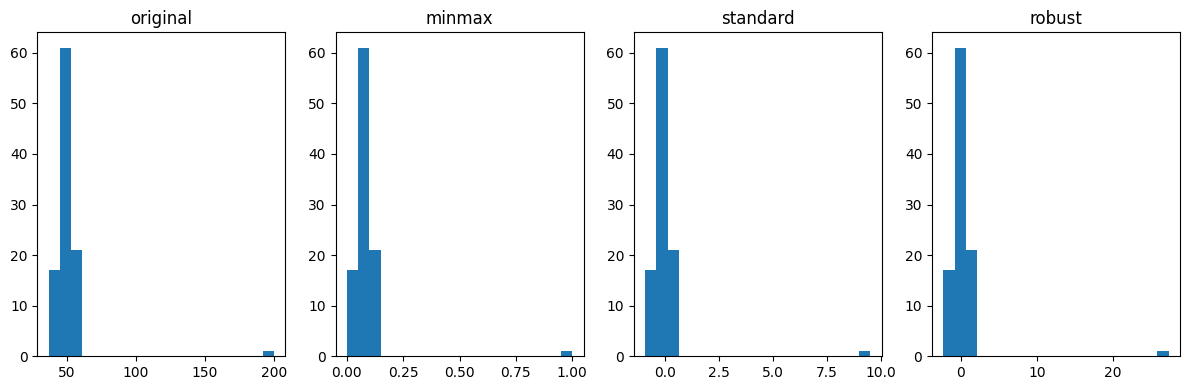

In [193]:
############ Comparativa entre tipos de escalamiento
# Datos normales con un outlier
np.random.seed(42)
data = np.random.normal(loc=50, scale=5, size=100)
data[-1] = 200  # outlier

df = pd.DataFrame({'original': data})

df['minmax'] = MinMaxScaler().fit_transform(df[['original']])
df['standard'] = StandardScaler().fit_transform(df[['original']])
df['robust'] = RobustScaler().fit_transform(df[['original']])

plt.figure(figsize=(12, 4))
for i, method in enumerate(['original', 'minmax', 'standard', 'robust']):
    plt.subplot(1, 4, i+1)
    plt.hist(df[method], bins=20)
    plt.title(method)
plt.tight_layout()
plt.show()

#### Conclusión
- Scalers DO NOT change the data distribution, they just find a new data range.
- We say min-max and standard scaling are less resistance to OUTLIERs because:
            - MAX and MIN values are affected by outliers.
            - STD and MEAN are affected by outliers
            - RobustScaler uses IQRs , which are not affected by outliers.
- Both minmax and standard "crush" your data into a small data range, which can make some algorithms hard to interpret the difference between data in the same range.

- Not all models require scaling:  - RandomForest, XGBoost, LightGBM , etc. Verify first.
- If values are already clean and well distributed, minmax and standard scaling might be enough.
- Some algorithms may need specific value ranges to operate correctly: [0, 1] or [-1, 1]for NeuralNetworks.

## Distribution Transformation

Sometimes it would be prefereable to first shrink skewed distributions, before scaling.
Possible solutions:
- log scaling
- sqr root scaling]
- bucketizing with equal sized buckets : i.e. quartile bucketizing

If there are multimode distributions, it could be useful to use the following transformations:
- Bucketizing in columns (one-hot-encoding)
- Using RBF (radial basis function) , i.e. Gaussing RBF ( measure the distance from the mode/ s)

In [194]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Log Scaling
log_transformer = FunctionTransformer(np.log10, lambda x: 10**x ) # here we define the inverse transform aswell.
log_population = log_transformer.fit_transform(housing["population"])

<Axes: >

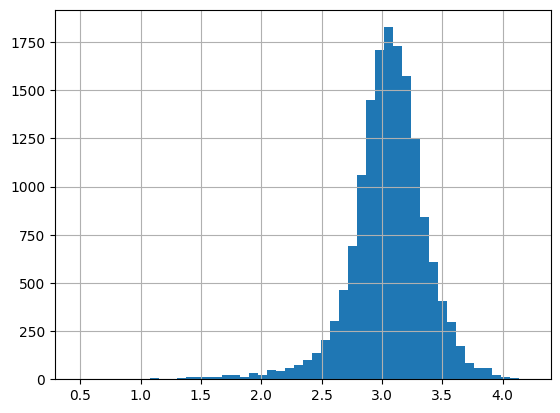

In [201]:
log_population.hist(bins=50)

In [202]:
# Sqrt Scaling
sqrt_transformer = FunctionTransformer(np.sqrt, lambda x : x**2) 

In [203]:
households_sqrt_scaled = sqrt_transformer.fit_transform(housing["households"])

<Axes: >

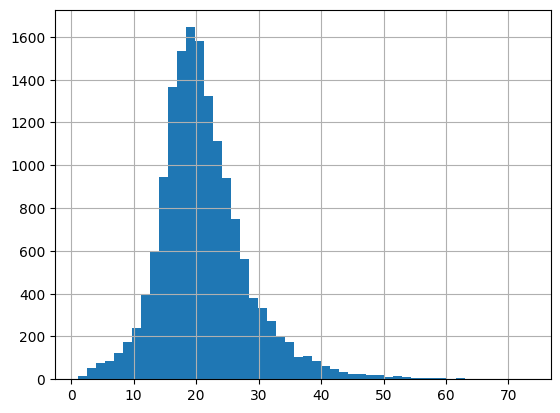

In [204]:
households_sqrt_scaled.hist(bins=50)

<Axes: >

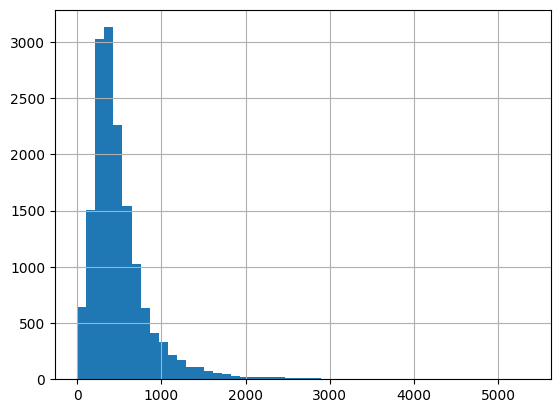

In [206]:
housing["households"].hist(bins=50)

In [208]:
#RBF Gaussian
from sklearn.metrics.pairwise import rbf_kernel

In [213]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [231]:
age_simil_35_vs_median_age = pd.DataFrame(data={"age_simil_35": age_simil_35[:,0],
                   "housing_median_age" : housing["housing_median_age"]
                   })

In [233]:
age_simil_35_vs_median_age.columns

Index(['age_simil_35', 'housing_median_age'], dtype='object')

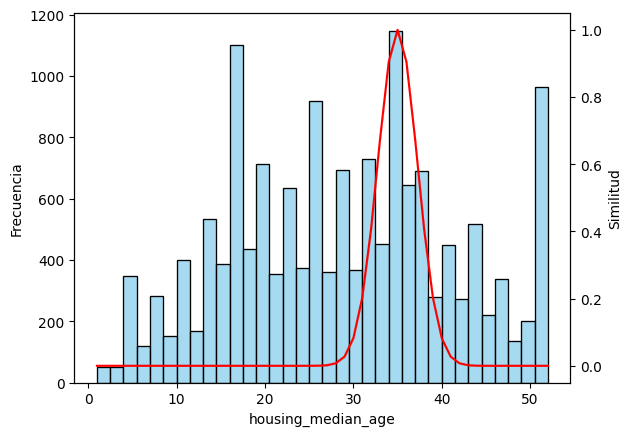

In [240]:
fig, ax1 = plt.subplots()
sns.histplot(data=age_simil_35_vs_median_age, x="housing_median_age", ax=ax1, color="skyblue")
ax1.set_ylabel("Frecuencia")

ax2 = ax1.twinx()

sns.lineplot(data=age_simil_35_vs_median_age, x="housing_median_age", y="age_simil_35", ax=ax2, color="red")
ax2.set_ylabel("Similitud")

plt.show()

## Inverse Transform

Useful when we have to perform transformations in the label/target dataset.
If we do this, we will not be predicting the variable, but the transformation(s) applied to it.
For this , we can use inverse_transform() of the transformer class.

In [269]:
#for example lets apply inverse transform to the target value
from sklearn.linear_model import LinearRegression

In [270]:
# lets apply some transfomation to our labels
std_scaler = StandardScaler()
housing_labels_std_scaled = std_scaler.fit_transform(pd.DataFrame(housing_labels))

In [271]:
linear_model = LinearRegression()
linear_model.fit(housing[["median_income"]], housing_labels_std_scaled)

LinearRegression()

In [274]:
predictions_log = linear_model.predict(housing[["median_income"]].head())
predictions_log

array([[-0.84333965],
       [-0.64135826],
       [-0.3569702 ],
       [-0.38581434],
       [-0.65905561]])

In [ ]:
# We apply the inverse transform of the transformer to the predicted values to get the actual predictions.
std_scaler.inverse_transform(predictions_log)

array([[109073.11496036],
       [132395.19081549],
       [165232.47303544],
       [161901.94186602],
       [130351.74070025]])

#### Simpler option: TransformedTargetRegressor()

In [276]:
from sklearn.compose import TransformedTargetRegressor

In [ ]:
#creamos el model.
# Definimos el regressor (estimador)
# Definimos el transformador (transformer)
model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=StandardScaler())

In [279]:
model.fit(housing[['median_income']], housing_labels )

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [280]:
predictions = model.predict(housing[['median_income']].head())

In [281]:
predictions

array([109073.11496036, 132395.19081549, 165232.47303544, 161901.94186602,
       130351.74070025])

## Custom Transformers 

Sometimes it will be necessary to create your own transformers.

We already used a custom transformer using FunctionTransformer and defining a log transformer.

New example. Create a transformer to measure the geographical similarity between a coordinate and san francisco coordinates. 

In [ ]:
# For this we can use the same RBF used previously
sf_coords = 37.7749, -122.41  # Coordinates of San Francisco
sf_transformer = FunctionTransformer(rbf_kernel, kw_args= dict(Y=[sf_coords], gamma= 0.1))

In [290]:
sf_simil = sf_transformer.fit_transform(housing[["latitude", "longitude"]])

In [291]:
sf_simil

array([[0.04944081],
       [0.45603688],
       [0.9835504 ],
       ...,
       [0.99963746],
       [0.03458657],
       [0.03067388]], shape=(15480, 1))

In [300]:
# We can use functiontransformers to combine features aswell.
ratio_transformer = FunctionTransformer(lambda X: X.iloc[:,0]/ X.iloc[:,1])
ratio_transformer.fit_transform(housing[['total_rooms', 'households']])

2787     2.970238
8717     5.311111
3521     4.784397
16026    6.011834
19572    4.506143
           ...   
11930    4.040501
9389     5.199346
17697    4.567059
3469     5.356401
9752     5.102117
Length: 15480, dtype: float64

## Custom Class Transformers

FunctionTransformer is very useful but, this transformers don't capture any information from the transformation, like some other scikitlearn transformers. 


In [ ]:
min_max_scaler.data_min_ # these store values from the trianed data. like tresholds, min, maxs, ranges, feature names, etc.

array([-124.35  ,   32.55  ,    1.    ,    2.    ,    1.    ,    3.    ,
          1.    ,    0.4999])

In this case, we want to create a class.
We need 3 methods:
- fit()
- transform()
- fit_transform()

BaseClass Inheritance: 
- TransformerMixin: We can get fit_transform() implementation for free if we add TransformerMixin as a base class
- BaseEstimator: get_params, set_params() (only if you don't use *args and **kwargs inside the constructor)


In [307]:
#Replicating standard scaler function
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean
    
    def fit(self, X, y=None):
        X = check_array(X)   # basic check
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator saves this
        return self #always return self!
    
    def transform(self, X):
        check_is_fitted(self) # checks if the object has been trained. looks for learned attributes (with trailing_)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean==True:
            X = X - self.mean_
        return  X / self.scale_


Some custom transformers use other estimators in its implementation. (Often actually)

In [315]:
# Creating a custom transformer using KMeans and RBF. 
# This transformer will calculate clusters using KMeans and calculate the similarity of entry data to each cluster.

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma=0.1, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters = self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [333]:
cluster_similarity_transformer = ClusterSimilarity(n_clusters=10)

In [334]:
cluster_simil = cluster_similarity_transformer.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [335]:
cluster_simil

array([[0.7906344 , 0.06859759, 0.96182415, ..., 0.89749671, 0.39777363,
        0.55007944],
       [0.79490834, 0.53464401, 0.28734116, ..., 0.54993627, 0.99920833,
        0.72770225],
       [0.23741866, 0.99839211, 0.03986542, ..., 0.17147369, 0.53825869,
        0.44794444],
       ...,
       [0.16635356, 0.98694024, 0.02338218, ..., 0.1150383 , 0.43169771,
        0.34176967],
       [0.74650183, 0.04901899, 0.99006155, ..., 0.80407379, 0.35090218,
        0.44478038],
       [0.69575918, 0.04367867, 0.99421731, ..., 0.81497594, 0.30967398,
        0.44268148]], shape=(15480, 10))

In [336]:
housing_cluster_simil = housing.copy()
housing_cluster_simil['cluster similarity'] = np.argmax(cluster_simil, axis=1)

In [337]:
housing_cluster_simil

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,cluster similarity
2787,-118.34,34.10,24.0,1996.0,791.0,1215.0,672.0,1.5429,<1H OCEAN,5
8717,-119.81,36.73,51.0,956.0,196.0,662.0,180.0,2.1010,INLAND,8
3521,-122.14,37.47,37.0,3373.0,815.0,2909.0,705.0,2.8868,NEAR BAY,1
16026,-116.89,33.48,14.0,1016.0,219.0,443.0,169.0,2.8071,INLAND,4
19572,-120.49,37.31,45.0,1834.0,421.0,1405.0,407.0,2.0521,INLAND,8
...,...,...,...,...,...,...,...,...,...,...
11930,-122.25,37.83,52.0,4190.0,1105.0,1786.0,1037.0,3.0897,NEAR BAY,1
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,<1H OCEAN,5
17697,-122.47,37.78,52.0,1941.0,436.0,955.0,425.0,4.1339,NEAR BAY,1
3469,-117.89,34.14,15.0,4644.0,967.0,2855.0,867.0,3.3654,<1H OCEAN,2


In [338]:
cluster_similarity_transformer.kmeans_.cluster_centers_

array([[  35.5348243 , -118.8789577 ],
       [  37.59559483, -122.15782606],
       [  33.847912  , -117.76930913],
       [  38.45747143, -121.14765305],
       [  32.94532489, -117.03137938],
       [  34.04443728, -118.31331714],
       [  39.36245851, -122.7612448 ],
       [  34.32744285, -119.35475512],
       [  36.79132946, -119.74551338],
       [  35.11456256, -120.56431754]])

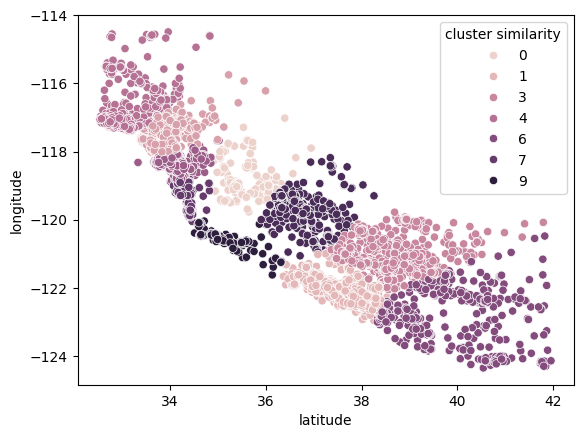

In [339]:
ax = sns.scatterplot(data=housing_cluster_simil, x='latitude', y='longitude', hue='cluster similarity')